In [1]:
import sys
import numpy as np

sys.path.insert(0, "..")

# Agents
from src.agents.robust_lin_exp3 import RobustLinExp3Agent

# Adversaries
from src.adversaries.adversary import Adversary
from src.adversaries.contextual_probabilistic_adversary import ContextualProbabilisticAdversary, ContextualTargetedProbabilisticAdversary

# Contexts
from src.contexts.context import Context
from src.contexts.gaussian_context import GaussianContext

# Environments
from src.environments.environment import Environment
from src.environments.adversarial_contextual_env import AdversarialContextualEnv

# Adversarial Contextual MAB bandits
from src.adversarial_contextual_mab import AdversarialContextualMAB

# Display
from src.display.visualization import Visualization as vis

In [2]:
# Init Vars
K = 5
h = 10000
epsilon = 0.0

# Init Context
num_ctx = 5
d = 5
ctx = GaussianContext(n_contexts=num_ctx, n_features=d, var=0.1)

print("context shape:", ctx.get_context().shape)

# Init Agent
name = "RobustLinExp3"
lr = h**(-2/3)*(K*d)**(-1/3)*np.log(K)**(2/3)
exploration_rate = h**(-1/3)*(K*d*np.log(K))**(1/3)
sigma = ctx.estimate_sigma(n_samples=10000)
ag = RobustLinExp3Agent(name=name, K=K, d=d, sigma=sigma, eta=lr, gamma=exploration_rate, epsilon=epsilon) 

# Calculate upper bound
bound_per_timestep = np.array([ag.compute_regret_bound(t) for t in range(h)])

context shape: (5,)


In [3]:
# Init Vars
K = 10
h = 10000
epsilon = 0.0

# Init Context
num_ctx = 5
d = 3
ctx = GaussianContext(n_contexts=num_ctx, n_features=d, var=0.1)

# Init Agent
name = "RobustLinExp3"
lr = h**(-2/3)*(K*d)**(-1/3)*np.log(K)**(2/3)
exploration_rate = h**(-1/3)*(K*d*np.log(K))**(1/3)
sigma = ctx.estimate_sigma(n_samples=10000)
ag = RobustLinExp3Agent(name=name, K=K, d=d, sigma=sigma, eta=lr, gamma=exploration_rate, epsilon=epsilon) 

# Calculate upper bound
bound_per_timestep = np.array([ag.compute_regret_bound(t) for t in range(h)])

## Experiment: Contextual Probabilistic Adversary ##

In [4]:
# Init adversary
ubs = [0.1, 0.3, 0.5, 0.7, 0.9]

# Play experiment
num_sim = 100
exp = AdversarialContextualMAB()

data_labels = []
cumulative_regrets = []
for ub in ubs:
    # Init Adversary
    adv = ContextualProbabilisticAdversary(K, d, h, eta=lr, gamma=exploration_rate, ub=ub)

    # Init Environment
    adv_env = AdversarialContextualEnv(adversary=adv, context=ctx)

    # Play experiment
    _, _, _, _, cumulative_regret, _ = exp.play(agent=ag, environment=adv_env, num_sim=num_sim, horizon=h)

    # Append cumulative regret
    cumulative_regrets.append(cumulative_regret)
    data_labels.append(f"Upper bound = {ub}")

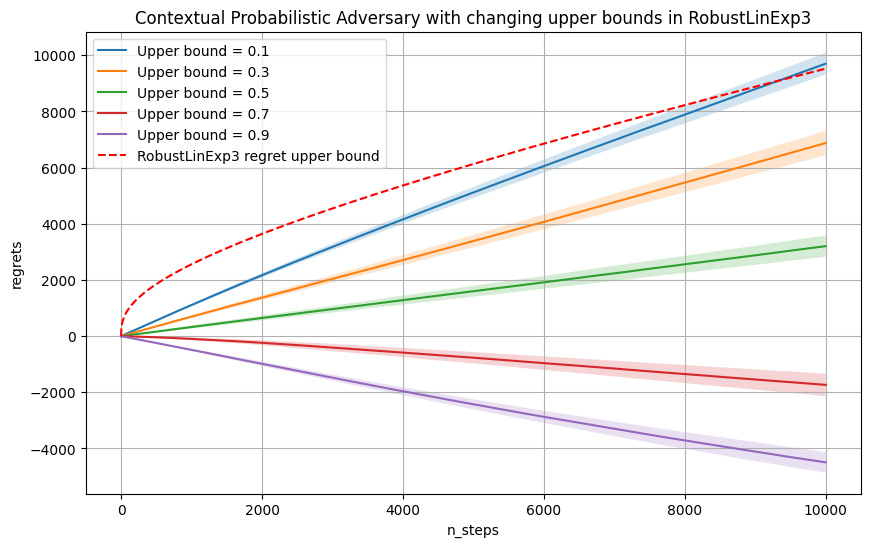

In [5]:
vis.plot_mean_std(
    data=cumulative_regrets, 
    data_labels=data_labels,
    title=f"Contextual Probabilistic Adversary with changing upper bounds in {name}", 
    xlabel="n_steps", 
    ylabel="regrets", 
    baseline=bound_per_timestep,
    baseline_title=f"{name} regret upper bound"
)